## 2. Multi-Variable Forcing Training
Goal: Enhance the baseline emulator by incorporating more inputs
- Phase 0: Surface air temperature (T_surf)
- Phase 1: + Sea surface temperature (SST), Sea ice concentration (SIC), land mask
- Phase 2: + Geopotential Height at 500 hPa (Z500)
- Phase 3: + Air temperature at the 850 hPa (T850)
- Phase 4: + Sea Level Pressure (SLP)

In [1]:
from utils.utils import process_variable, get_indices
from architectures.cnn_baseline import CNN2D_Baseline, set_seed
import logging
import numpy as np

logging.basicConfig(
    level=logging.INFO,
    format="%(name)s - %(levelname)s - %(message)s"
)

variables = [{'var_name': "t_ref",
              "file_name": "DATA/atmos.192101-201012.t_ref.nc",
              "add_spatial": True,
              "lag_data_set": True,
              "is_static": False,
              "standardize": True},
             {'var_name': "SST",
              "file_name": "DATA/ocean.192101-201012.SST.nc",
              "add_spatial": False,
              "lag_data_set": True,
              "is_static": False,
              "standardize": True},
             {'var_name': "T850",
              "file_name": "DATA/atmos.192101-201012.T850.nc",
              "add_spatial": False,
              "lag_data_set": True,
              "is_static": False,
              "standardize": True,
              "fill_value_method": "topomask"},
             {'var_name': "Z500",
              "file_name": "DATA/atmos.192101-201012.Z500.nc",
              "add_spatial": False,
              "lag_data_set": True,
              "is_static": False,
              "standardize": True},
             {'var_name': "slp",
              "file_name": "DATA/atmos.192101-201012.slp.nc",
              "add_spatial": False,
              "lag_data_set": True,
              "is_static": False,
              "standardize": True},
             {'var_name': "sic",
              "file_name": "DATA/ice.192101-201012.sic.nc",
              "add_spatial": False,
              "lag_data_set": True,
              "is_static": False,
              "standardize": False},
             {'var_name': "wet",
              "file_name": "DATA/ocean.static.nc",
              "add_spatial": False,
              "lag_data_set": False,
              "is_static": True,
              "standardize": False},
]

num_epochs = 50
Models = []


In [2]:
set_seed()
var_data = []
for variable in variables:
    var_name = variable['var_name']

    file_name = variable['file_name']
    add_spatial = variable['add_spatial']
    lag_data_set = variable['lag_data_set']
    is_static = variable['is_static']
    standardize = variable['standardize']
    fill_value_method = variable.get('fill_value_method')

    var_data.append(process_variable(file_name, var_name, lag_data_set,
                                     add_spatial, is_static, standardize,
                                     fill_value_method=fill_value_method))

t_ref - INFO - Working on var: t_ref from DATA/atmos.192101-201012.t_ref.nc
t_ref - INFO - X_train_scaled : (861, 7, 90, 90)
t_ref - INFO - X_test_scaled : (213, 7, 90, 90)
t_ref - INFO - y_train_scaled : (861, 1, 90, 90)
t_ref - INFO - y_test_scaled : (213, 1, 90, 90)
t_ref - INFO - y_train : (861, 90, 90)
t_ref - INFO - y_test : (213, 90, 90)
SST - INFO - Working on var: SST from DATA/ocean.192101-201012.SST.nc
SST - WARNING - Input data contains null values. Filling with 0. Need to mask
SST - INFO - X_train_scaled : (861, 3, 90, 90)
SST - INFO - X_test_scaled : (213, 3, 90, 90)
T850 - INFO - Working on var: T850 from DATA/atmos.192101-201012.T850.nc
T850 - WARNING - Input data contains null values. Filling with 0. Need to mask
T850 - INFO - X_train_scaled : (861, 4, 90, 90)
T850 - INFO - X_test_scaled : (213, 4, 90, 90)
Z500 - INFO - Working on var: Z500 from DATA/atmos.192101-201012.Z500.nc
Z500 - INFO - X_train_scaled : (861, 3, 90, 90)
Z500 - INFO - X_test_scaled : (213, 3, 90, 9

In [3]:
x_test_scaleds = []
x_train_scaleds = []

end = 0
for variable in var_data:
    if variable['varname'] == "t_ref":
        y_train_scaled = variable['y_train_scaled']
        y_test_scaled = variable['y_test_scaled']
        y_train = variable['y_train']
        y_test = variable['y_test']
        time_test = variable['time']
        nsamples_train = variable['X_train_scaled'].shape[0]
        nsamples_test = variable['X_test_scaled'].shape[0]

    start = end
    if variable['varname'] == "wet":
        end = start + 1
        static_train = np.broadcast_to(
            variable['X_train_scaled'],
            (nsamples_train,) + variable['X_train_scaled'].shape[1:]
        )
        static_test = np.broadcast_to(
            variable['X_test_scaled'],
            (nsamples_test,) + variable['X_test_scaled'].shape[1:]
        )

        x_train_scaleds.append(static_train)
        x_test_scaleds.append(static_test)
    else:
        end = start + variable['X_test_scaled'].shape[1]
        x_test_scaleds.append(variable['X_test_scaled'])
        x_train_scaleds.append(variable['X_train_scaled'])

    variable['start'] = start
    variable['end'] = end
        
X_train_scaled = np.concatenate(x_train_scaleds, axis=1)
X_test_scaled = np.concatenate(x_test_scaleds, axis=1)

logging.info(f"X_train_scaled : {X_train_scaled.shape}")
logging.info(f"y_train_scaled : {y_train_scaled.shape}")
logging.info(f"X_test_scaled : {X_test_scaled.shape}")
logging.info(f"y_test_scaled : {y_test_scaled.shape}")
logging.info(f"y_train : {y_train.shape}")
logging.info(f"y_test : {y_test.shape}")

root - INFO - X_train_scaled : (861, 24, 90, 90)
root - INFO - y_train_scaled : (861, 1, 90, 90)
root - INFO - X_test_scaled : (213, 24, 90, 90)
root - INFO - y_test_scaled : (213, 1, 90, 90)
root - INFO - y_train : (861, 90, 90)
root - INFO - y_test : (213, 90, 90)


root - INFO - X_train_scaled : (861, 7, 90, 90)
root - INFO - X_test_scaled : (213, 7, 90, 90)


Model Architecture:
Sequential(
  (0): Conv2d(7, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 

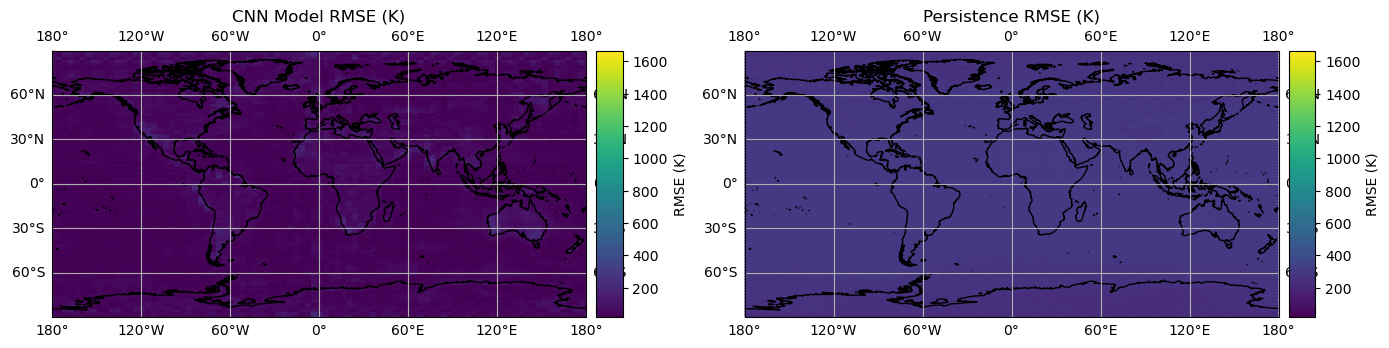

In [4]:
variable_set = ["t_ref"]
indices = get_indices(var_data, variable_set)
X_train_scaled_prime = np.concatenate([X_train_scaled[:, start:end, :, :] for start, end in indices], axis=1)
X_test_scaled_prime = np.concatenate([X_test_scaled[:, start:end, :, :] for start, end in indices], axis=1)
logging.info(f"X_train_scaled : {X_train_scaled_prime.shape}")
logging.info(f"X_test_scaled : {X_test_scaled_prime.shape}")

set_seed()
step1 = CNN2D_Baseline(in_channels=X_train_scaled_prime.shape[1], case=2, label="Phase0")
train_loader, test_loader = step1.create_data_loaders(X_train_scaled_prime, y_train_scaled, X_test_scaled_prime, y_test_scaled)
step1.train_model(train_loader, test_loader, num_epochs=num_epochs)
step1.get_rmse(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled, ranges=(17.449455, 1665.3541))
RMSE = step1.get_global_rmse_over_time(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled)
Models.append({'Model Name': 'Baseline', 'Trained Model': step1, 'RMSE': RMSE, 'Slope': None})

root - INFO - X_train_scaled : (861, 14, 90, 90)
root - INFO - X_test_scaled : (213, 14, 90, 90)


Model Architecture:
Sequential(
  (0): Conv2d(14, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Conv2d(16, 1, kernel_size=(3, 3), stride=(1,

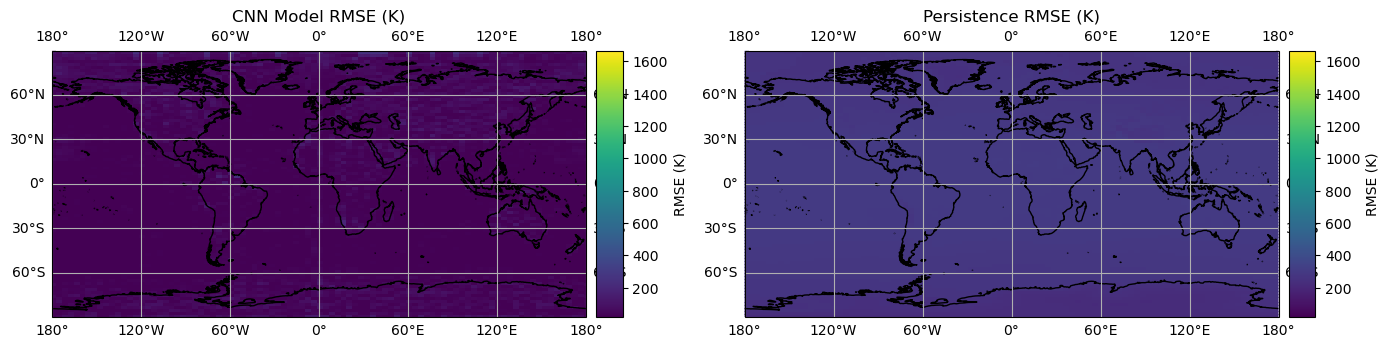

In [5]:

variable_set = ["t_ref", "SST", "sic", "wet"]
indices = get_indices(var_data, variable_set)
X_train_scaled_prime = np.concatenate([X_train_scaled[:, start:end, :, :] for start, end in indices], axis=1)
X_test_scaled_prime = np.concatenate([X_test_scaled[:, start:end, :, :] for start, end in indices], axis=1)
logging.info(f"X_train_scaled : {X_train_scaled_prime.shape}")
logging.info(f"X_test_scaled : {X_test_scaled_prime.shape}")

set_seed()
step1 = CNN2D_Baseline(in_channels=X_train_scaled_prime.shape[1], case=2, label="Phase1")
train_loader, test_loader = step1.create_data_loaders(X_train_scaled_prime, y_train_scaled, X_test_scaled_prime, y_test_scaled)
step1.train_model(train_loader, test_loader, num_epochs=num_epochs)
step1.get_rmse(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled, ranges=(17.449455, 1665.3541))
RMSE = step1.get_global_rmse_over_time(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled)
Models.append({'Model Name': '+ SST + sic + wet', 'Trained Model': step1, 'RMSE': RMSE, 'Slope': None})


root - INFO - X_train_scaled : (861, 17, 90, 90)
root - INFO - X_test_scaled : (213, 17, 90, 90)


Model Architecture:
Sequential(
  (0): Conv2d(17, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Conv2d(16, 1, kernel_size=(3, 3), stride=(1,

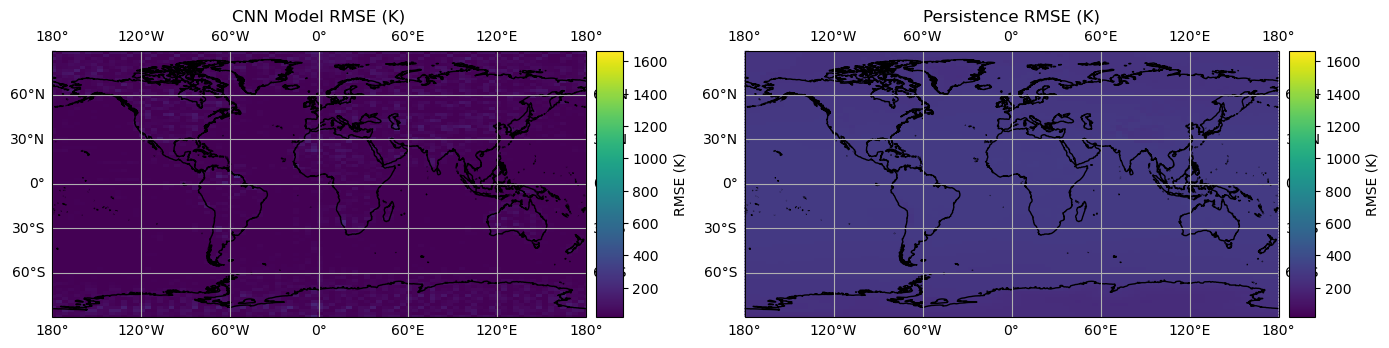

In [6]:
variable_set = ["t_ref", "SST", "sic", "wet", "Z500"]
indices = get_indices(var_data, variable_set)
X_train_scaled_prime = np.concatenate([X_train_scaled[:, start:end, :, :] for start, end in indices], axis=1)
X_test_scaled_prime = np.concatenate([X_test_scaled[:, start:end, :, :] for start, end in indices], axis=1)
logging.info(f"X_train_scaled : {X_train_scaled_prime.shape}")
logging.info(f"X_test_scaled : {X_test_scaled_prime.shape}")

set_seed()
step2 = CNN2D_Baseline(in_channels=X_train_scaled_prime.shape[1], case=2, label="Phase2")
train_loader, test_loader = step2.create_data_loaders(X_train_scaled_prime, y_train_scaled, X_test_scaled_prime, y_test_scaled)
step2.train_model(train_loader, test_loader, num_epochs=num_epochs)
step2.get_rmse(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled, ranges=(17.449455, 1665.3541))
RMSE = step2.get_global_rmse_over_time(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled)
Models.append({'Model Name': '+ Z500', 'Trained Model': step2, 'RMSE': RMSE, 'Slope': None})



root - INFO - X_train_scaled : (861, 21, 90, 90)
root - INFO - X_test_scaled : (213, 21, 90, 90)


Model Architecture:
Sequential(
  (0): Conv2d(21, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Conv2d(16, 1, kernel_size=(3, 3), stride=(1,

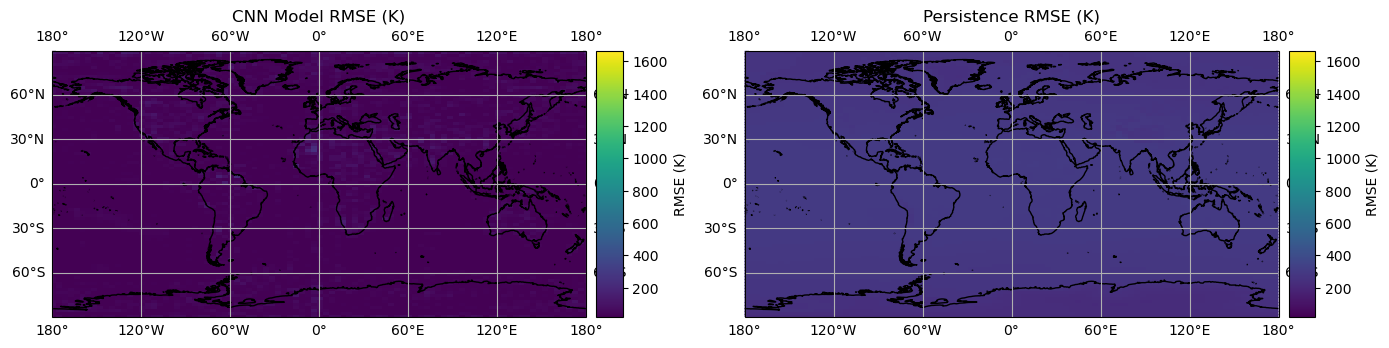

In [7]:
variable_set = ["t_ref", "SST", "sic", "wet", "Z500", "T850"]
indices = get_indices(var_data, variable_set)
X_train_scaled_prime = np.concatenate([X_train_scaled[:, start:end, :, :] for start, end in indices], axis=1)
X_test_scaled_prime = np.concatenate([X_test_scaled[:, start:end, :, :] for start, end in indices], axis=1)
logging.info(f"X_train_scaled : {X_train_scaled_prime.shape}")
logging.info(f"X_test_scaled : {X_test_scaled_prime.shape}")

set_seed()
step3 = CNN2D_Baseline(in_channels=X_train_scaled_prime.shape[1], case=2, label="Phase3")
train_loader, test_loader = step3.create_data_loaders(X_train_scaled_prime, y_train_scaled, X_test_scaled_prime, y_test_scaled)
step3.train_model(train_loader, test_loader, num_epochs=num_epochs)
step3.get_rmse(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled, ranges=(17.449455, 1665.3541))
RMSE = step3.get_global_rmse_over_time(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled)
Models.append({'Model Name': '+ T850', 'Trained Model': step3, 'RMSE': RMSE, 'Slope': None})

root - INFO - X_train_scaled : (861, 21, 90, 90)
root - INFO - X_test_scaled : (213, 21, 90, 90)


Model Architecture:
Sequential(
  (0): Conv2d(21, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Conv2d(16, 1, kernel_size=(3, 3), stride=(1,

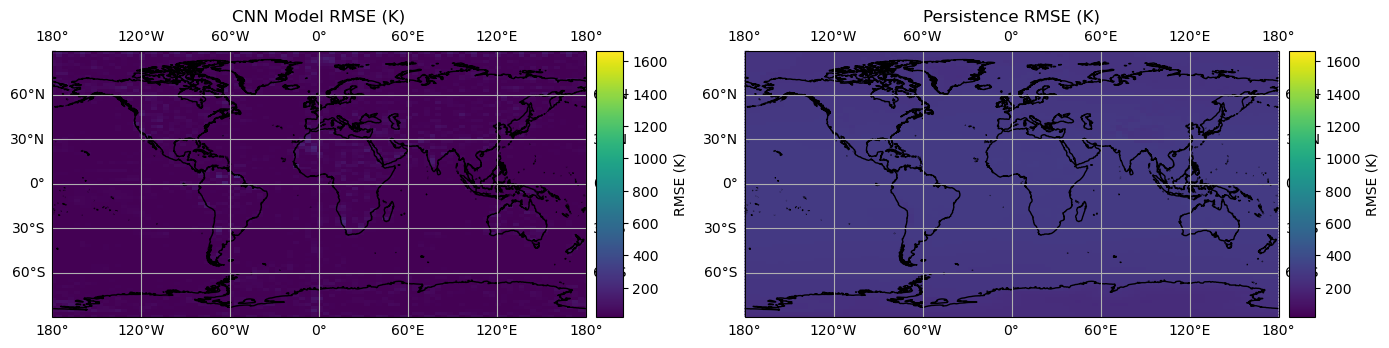

In [8]:
variable_set = ["t_ref", "SST", "sic", "wet", "Z500", "T850", "SLP"]

indices = get_indices(var_data, variable_set)
X_train_scaled_prime = np.concatenate([X_train_scaled[:, start:end, :, :] for start, end in indices], axis=1)
X_test_scaled_prime = np.concatenate([X_test_scaled[:, start:end, :, :] for start, end in indices], axis=1)
logging.info(f"X_train_scaled : {X_train_scaled_prime.shape}")
logging.info(f"X_test_scaled : {X_test_scaled_prime.shape}")

set_seed()
step4 = CNN2D_Baseline(in_channels=X_train_scaled_prime.shape[1], case=2, label="Phase4")
train_loader, test_loader = step4.create_data_loaders(X_train_scaled_prime, y_train_scaled, X_test_scaled_prime, y_test_scaled)
step4.train_model(train_loader, test_loader, num_epochs=num_epochs)
step4.get_rmse(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled, ranges=(17.449455, 1665.3541))
RMSE = step4.get_global_rmse_over_time(var_data[0]['tas_data'], X_test_scaled_prime, y_test_scaled)
Models.append({'Model Name': '+ SLP', 'Trained Model': step4, 'RMSE': RMSE, 'Slope': None})

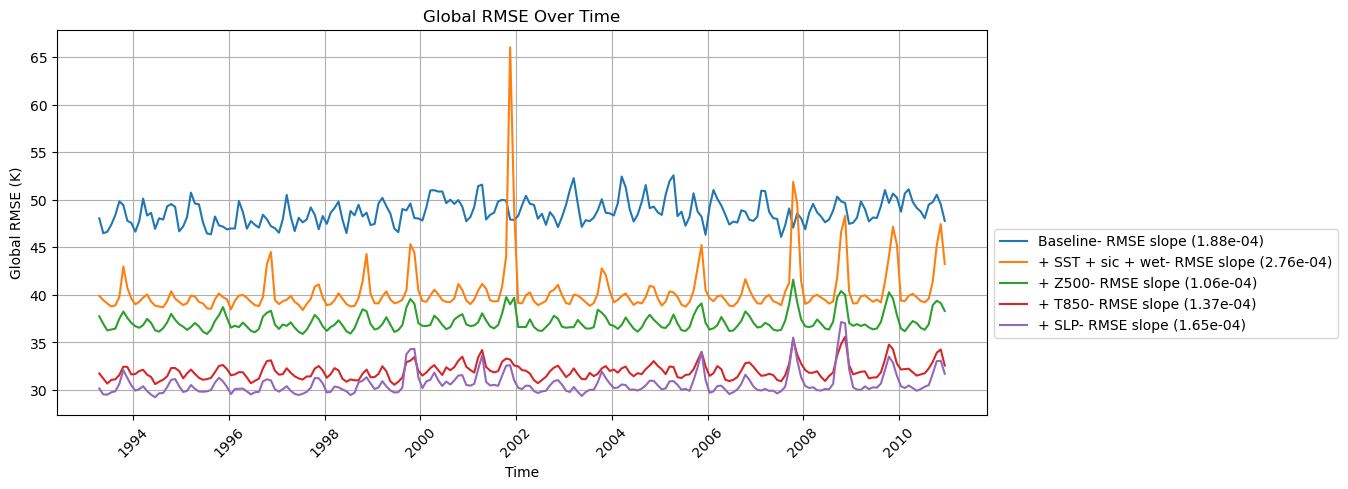

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import numpy as np

time_test_plot = np.array([np.datetime64(t) for t in time_test])
plt.figure(figsize=(12,5))
for Model in Models:
    rmse = Model['RMSE']
    name = Model['Model Name']

    x = time_test_plot[3:].astype('datetime64[D]').astype(float)
    Model['slope'], intercept, r_value, p_value, std_err = linregress(x, rmse)
    plt.plot(time_test_plot[3:], rmse, label=f"{name}- RMSE slope ({Model['slope']:.2e})")


plt.xlabel("Time")
plt.ylabel("Global RMSE (K)")
plt.title("Global RMSE Over Time")
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))  # every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.show()